In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from gap_statistic import OptimalK
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
import os
import glob

In [15]:
# Read in the PCA dataset and set the index
df = pd.read_csv('full_dataset_with_PCA.csv')
df.set_index(['Season', 'Player'], inplace=True)

In [16]:
df

PC1       PC2       PC3       PC4       PC5
Season Player                                                          
2001   A.C. Green      0.731723 -1.297794 -1.701517  1.693110  1.330470
       A.J. Guyton    -2.892228 -1.521408 -1.135181  0.713153  0.375435
       Aaron McKie    -1.917119  0.679172  0.410573  0.731380  0.600381
       Aaron Williams  3.583582  0.397426  0.042290  0.476243 -0.248848
       Adam Keefe      1.225871 -1.549828 -0.667852  0.542559  1.060138
...                         ...       ...       ...       ...       ...
2019   Zaza Pachulia   3.087243  0.275098  1.130487  1.226967  0.730044
       Zhaire Smith   -0.909462 -1.079707  0.809244 -0.791178 -0.581445
       Zhou Qi         3.038855  2.385574 -2.135677 -5.924793 -0.698782
       Álex Abrines   -2.336488 -3.224558  0.350052 -1.208737 -1.252402
       Ángel Delgado   3.282497 -0.678330  0.824750 -0.845540  0.856803

[8870 rows x 5 columns]

In [18]:
# Drop the indexes and convert DataFrame to NumPy array
pca_data = df.reset_index(drop=True)
data_array = pca_data.values

def optimalK(data, max_clusters):
    results = []  # List to hold results
    
    nrefs=5
    gaps = np.zeros((len(range(1, max_clusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, max_clusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
            clusters = ward.fit_predict(randomReference)
            
            # Calculate centroids for each cluster
            centroids = np.array([randomReference[clusters == j].mean(axis=0) for j in range(k)])

            # Calculate the sum of squared distances
            _, distances = pairwise_distances_argmin_min(randomReference, centroids)
            ward_inertia = np.sum(distances ** 2)
            
            refDisp = ward_inertia
            refDisps[i] = refDisp
        
        # Fit cluster to original data and create dispersion
        ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
        clusters = ward.fit_predict(data)
        
        # Calculate centroids for each cluster
        centroids = np.array([data[clusters == j].mean(axis=0) for j in range(k)])

        # Calculate the sum of squared distances
        _, distances = pairwise_distances_argmin_min(data, centroids)
        ward_inertia = np.sum(distances ** 2)
        
        origDisp = ward_inertia
        
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        results.append({'clusterCount': k, 'gap': gap})  # Append the results to the list
        resultsdf = pd.DataFrame(results)
    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [19]:
k, gapdf = optimalK(data_array, max_clusters=25)
print('Optimal k is: ', k)

Optimal k is:  4


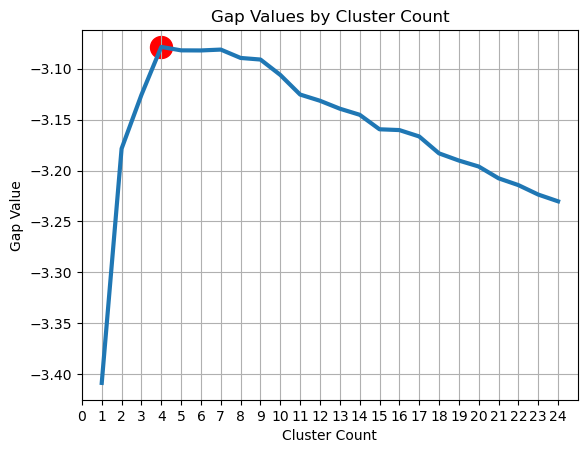

In [20]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlim(0, max(gapdf.clusterCount + 1))
plt.xticks(np.arange(0, max(gapdf.clusterCount) + 1, 1))
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [21]:
values = df.values

# Create the model
n_clusters = 12
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Fit the model
cluster_labels = clustering.fit_predict(values)

# Assign clusters back to the df
df['Cluster'] = cluster_labels + 1

In [22]:
df

PC1       PC2       PC3       PC4       PC5  \
Season Player                                                             
2001   A.C. Green      0.731723 -1.297794 -1.701517  1.693110  1.330470   
       A.J. Guyton    -2.892228 -1.521408 -1.135181  0.713153  0.375435   
       Aaron McKie    -1.917119  0.679172  0.410573  0.731380  0.600381   
       Aaron Williams  3.583582  0.397426  0.042290  0.476243 -0.248848   
       Adam Keefe      1.225871 -1.549828 -0.667852  0.542559  1.060138   
...                         ...       ...       ...       ...       ...   
2019   Zaza Pachulia   3.087243  0.275098  1.130487  1.226967  0.730044   
       Zhaire Smith   -0.909462 -1.079707  0.809244 -0.791178 -0.581445   
       Zhou Qi         3.038855  2.385574 -2.135677 -5.924793 -0.698782   
       Álex Abrines   -2.336488 -3.224558  0.350052 -1.208737 -1.252402   
       Ángel Delgado   3.282497 -0.678330  0.824750 -0.845540  0.856803   

                       Cluster  
Season Player                   
2001   A.C. Green            9  
       A.J. Guyton           2  
       Aaron McKie           6  
       Aaron Williams        5  
       Adam Keefe           12  
...                        ...  
2019   Zaza Pachulia         5  
       Zhaire Smith         10  
       Zhou Qi               3  
       Álex Abrines          2  
       Ángel Delgado         7  

[8870 rows x 6 columns]

In [23]:
# Read in the raw data to analyze how the averages for different clusters
pre_pca = pd.read_csv('full_dataset_before_PCA.csv')
pre_pca.set_index(['Season', 'Player'], inplace=True)
pre_pca['Cluster'] = cluster_labels + 1

In [24]:
# Sort by cluster to see the median value of each statistic for each cluster
cluster_medians = pre_pca.reset_index(drop=True).groupby('Cluster').median()

In [25]:
cluster_medians

,USG%,FGA,Personal Fouls Committed,BLK,STL,DRB,ORB,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Shooting Fouls Drawn,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,Dunks - %FGA
Cluster,,,,,,,,,,,,,,,,,,,,
1,24.8,20.033533,3.450189,0.359102,1.880509,4.403591,1.010020,3.953395,7.938535,0.664,0.2530,0.3150,2.373234,0.1230,0.2620,0.179,0.103,0.137,0.2810,0.007
2,15.7,14.000000,3.889389,0.461135,1.225673,4.768559,1.004651,1.714286,2.644311,0.962,0.6400,0.1500,0.777778,0.3330,0.4910,0.188,0.070,0.067,0.1500,0.010
3,23.4,18.737349,4.800000,1.452973,1.143830,8.529892,3.693913,3.116324,2.584615,0.500,0.6300,0.3410,2.926419,0.0830,0.0120,0.200,0.158,0.222,0.3410,0.063
4,13.3,9.074352,6.602346,2.005341,1.240441,8.515578,5.066394,2.391780,1.340041,0.000,0.6670,0.6190,2.406332,0.0000,0.0000,0.020,0.036,0.182,0.7200,0.221
5,16.5,12.643902,6.241373,1.990909,1.078519,8.285178,4.504459,2.588764,1.637795,0.000,0.6500,0.3770,2.080495,0.0000,0.0000,0.066,0.105,0.255,0.5180,0.114
6,18.0,14.620690,3.834320,0.253479,1.688073,3.840000,0.786414,2.931480,6.557377,0.818,0.3480,0.2020,1.064039,0.2070,0.3480,0.235,0.091,0.094,0.2000,0.000
7,16.5,13.211650,4.961485,1.182609,1.491429,6.998131,3.278049,2.378801,2.456172,1.000,0.6590,0.3340,1.964194,0.3700,0.1290,0.124,0.066,0.145,0.4500,0.104
8,24.0,19.682209,3.600515,0.513999,1.465373,5.163902,1.443013,3.083430,4.132449,0.882,0.4785,0.2975,2.436784,0.2385,0.2145,0.242,0.124,0.125,0.2590,0.026
9,14.8,12.096000,6.442999,1.280000,1.018388,6.973777,3.394475,2.218545,1.802363,0.000,0.7220,0.2240,1.113043,0.0000,0.0000,0.265,0.222,0.167,0.2930,0.032


In [29]:
pre_pca[pre_pca['Cluster'] == 5]

USG%        FGA  Personal Fouls Committed       BLK  \
Season Player                                                                  
2001   Aaron Williams    17.8  13.310959                  6.571233  2.358904   
       Adonal Foyle      14.0  12.420041                  4.394784  5.159094   
       Art Long          15.2   8.640000                 12.960000  6.480000   
       Bill Curley       15.8  12.000000                 11.500000  2.500000   
       Brian Skinner     17.3  13.142466                  5.128767  0.961644   
...                       ...        ...                       ...       ...   
2019   Rudy Gobert       17.8  13.276834                  4.375320  3.470081   
       Steven Adams      16.4  14.531285                  3.740727  1.438741   
       Tony Bradley      23.6  21.200000                  8.000000  2.800000   
       Tristan Thompson  17.7  15.161269                  3.618030  0.689149   
       Zaza Pachulia     15.0  10.409112                  8.178588  1.115262   

                              STL        DRB        ORB       TOV       AST  \
Season Player                                                                 
2001   Aaron Williams    1.179452   7.750685   4.380822  2.695890  1.853425   
       Adonal Foyle      0.955388   8.216335   5.159094  2.675086  1.528620   
       Art Long          0.000000  15.120000   4.320000  4.320000  2.160000   
       Bill Curley       2.000000   4.000000   5.500000  4.000000  1.000000   
       Brian Skinner     1.282192   9.295890   4.487671  2.564384  1.602740   
...                           ...        ...        ...       ...       ...   
2019   Rudy Gobert       1.206985  13.578580   5.733178  2.413970  3.017462   
       Steven Adams      2.158112   6.618209   7.049831  2.445860  2.301986   
       Tony Bradley      2.800000   8.000000  12.000000  4.000000  1.200000   
       Tristan Thompson  1.206010  10.681803   6.891486  2.412020  3.445743   
       Zaza Pachulia     1.858770   8.922096   5.576310  2.974032  4.832802   

                         % of FG Ast'd - 3P  ...    FTr  Shooting Fouls Drawn  \
Season Player                                ...                                
2001   Aaron Williams                   0.0  ...  0.477              2.691781   
       Adonal Foyle                     0.0  ...  0.181              0.955388   
       Art Long                         0.0  ...  0.500              0.000000   
       Bill Curley                      1.0  ...  0.404              2.000000   
       Brian Skinner                    0.0  ...  0.366              2.054795   
...                                     ...  ...    ...                   ...   
2019   Rudy Gobert                      0.0  ...  0.733              4.284051   
       Steven Adams                     0.0  ...  0.361              1.978269   
       Tony Bradley                     0.0  ...  0.125              1.333333   
       Tristan Thompson                 0.0  ...  0.279              1.682805   
       Zaza Pachulia                    0.0  ...  0.642              2.624146   

                         Corner 3s - %3PA  % of FGA by Distance - 3P  \
Season Player                                                          
2001   Aaron Williams                 0.0                      0.003   
       Adonal Foyle                   0.0                      0.000   
       Art Long                       0.0                      0.000   
       Bill Curley                    0.5                      0.043   
       Brian Skinner                  0.0                      0.000   
...                                   ...                        ...   
2019   Rudy Gobert                    0.0                      0.000   
       Steven Adams                   0.0                      0.002   
       Tony Bradley                   0.0                      0.000   
       Tristan Thompson               0.0                      0.000   
       Zaza Pachulia                  